In [63]:
import os
import numpy as np
import librosa
import soundfile as sf
from basic_pitch.inference import predict
from basic_pitch import ICASSP_2022_MODEL_PATH
import music21
from pathlib import Path
from basic_pitch import constants as bp_constants
import pretty_midi
import scipy
HOP_LENGTH = bp_constants.FFT_HOP
SAMPLING_RATE = bp_constants.AUDIO_SAMPLE_RATE
MIDI_OFFSET = 21 # basic_pitchのピッチ配列のMIDIノート番号オフセット (=21, A0)
# 人が歌える音域の範囲
LOWEST_PITCH = 15 # C2 (MIDI 36)
HIGHEST_PITCH = 67 # E6 (MIDI 88)

# MuseScore 4のパスを明示的に設定
# ユーザーが確認したパス: /Applications/MuseScore4.app/Contents/MacOS/mscore
musescore_path = Path('/Applications/MuseScore 3.app/Contents/MacOS/mscore')

if musescore_path.exists():
    us = music21.environment.UserSettings()
    us['musicxmlPath'] = str(musescore_path)
    us['musescoreDirectPNGPath'] = str(musescore_path)
    
    print(f"MuseScore path successfully set to: {musescore_path}")
else:
    print(f"Warning: MuseScore not found at {musescore_path}. Please check the installation path.")

MuseScore path successfully set to: /Applications/MuseScore 3.app/Contents/MacOS/mscore


In [13]:
sound_name = "sample_kaze"

data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
transcription_path = os.path.join(data_path, "processed", "transcribed", sound_name)
# 元の音声ファイル
original_file = os.path.join(data_path, "original", f"{sound_name}.mp4")
# 分離済みのボーカル音声ファイル
# input_file = os.path.join(data_path, "processed", "UVR", sound_name, f"{sound_name}_(Vocals)_UVR_MDXNET_KARA_(No Reverb)_UVR-DeEcho-DeReverb.wav")
input_file = os.path.join(data_path, "processed", "htdemucs", sound_name, "vocals.mp3")
inst_file = os.path.join(data_path, "processed", "UVR", sound_name, f"{sound_name}_(Instrumental)_UVR_MDXNET_KARA.wav")
harmonic_file = os.path.join(transcription_path, f"{sound_name}_Harmonic.wav")
output_midi_path = os.path.join(transcription_path, 'vocals_transcribed.mid')

In [14]:
# 1. チューニング補正量を計算 (元の音源から)
y_inst_raw, sr = librosa.load(inst_file)
tuning_offset = librosa.estimate_tuning(y=y_inst_raw, sr=sr)
print(f"Estimated tuning offset: {tuning_offset:.3f} bins")

# 2. リサンプリングでピッチ補正 (音質劣化なし・時間軸が変わる)
tuning_rate = 2 ** (-tuning_offset / 12)
print(f"Tuning rate: {tuning_rate:.4f}")

y_inst = librosa.resample(y_inst_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Inst duration: {len(y_inst_raw)/sr:.2f}s -> {len(y_inst)/sr:.2f}s (resampled)")

# 3. リサンプリング後の音源からビート検出
tempo = librosa.feature.tempo(y=y_inst, sr=sr)
tempo, beat_track = librosa.beat.beat_track(y=y_inst, sr=sr, hop_length=HOP_LENGTH, start_bpm=tempo[0], units='frames')
print(f"Detected tempo: {float(tempo[0]):.1f} BPM, {len(beat_track)} beats")

Estimated tuning offset: -0.310 bins
Tuning rate: 1.0181
Inst duration: 69.24s -> 68.01s (resampled)
Detected tempo: 94.0 BPM, 106 beats


In [15]:
# 4. ボーカル音源も同じtuning_rateでリサンプリング
y_vocal_raw, sr = librosa.load(input_file)
if sr != SAMPLING_RATE:
    raise ValueError(f"Sample rate of input file ({sr}) does not match expected sample rate ({SAMPLING_RATE})")

y_vocal = librosa.resample(y_vocal_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Vocal duration: {len(y_vocal_raw)/sr:.2f}s -> {len(y_vocal)/sr:.2f}s (resampled)")

# Harmonic/Percussive Source Separation (HPSS)
y_harmonic, _ = librosa.effects.hpss(y_vocal, margin=1.0)

sf.write(harmonic_file, y_harmonic, sr)
print(f"Saved harmonic component to {harmonic_file}")

Vocal duration: 69.28s -> 68.05s (resampled)
Saved harmonic component to /Users/kpome/github/solfege-gen/data/processed/transcribed/sample_kaze/sample_kaze_Harmonic.wav


In [16]:
model_output, midi_data, _ = predict(
    harmonic_file,
    model_or_model_path=ICASSP_2022_MODEL_PATH,
    onset_threshold=0.5, # 無関係
    frame_threshold=0.3, # 無関係
    minimum_note_length=20, # 無関係
    maximum_frequency=2000,
    multiple_pitch_bends=False,
    melodia_trick=True,
    midi_tempo=float(tempo) # 無関係
    )
# MIDIデータをファイルに保存する
output_midi_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'processed', 'vocals_transcribed.mid')
midi_data.write(output_midi_path)
print(f"saved to {output_midi_path}")

Predicting MIDI for /Users/kpome/github/solfege-gen/data/processed/transcribed/sample_kaze/sample_kaze_Harmonic.wav...
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_29515/1160285728.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  midi_tempo=float(tempo) # 無関係


isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844, 1)
dtype: float32
isfinite: True
shape: (1, 43844

In [17]:
# 1秒あたりのフレーム数を取得
# FPS = bp_constants.ANNOTATIONS_FPS
SPF = HOP_LENGTH / SAMPLING_RATE
print(f"Seconds per frame: {SPF:.6f} sec/frame")
onsets_np = model_output['onset']  # shape: (num_frames, num_pitches)
print(f"onsets_np shape: {onsets_np.shape}")
pitches_np = model_output['note']  # shape: (num_frames, num_pitches)
print(f"pitches_np shape: {pitches_np.shape}")

Seconds per frame: 0.011610 sec/frame
onsets_np shape: (5852, 88)
pitches_np shape: (5852, 88)


In [18]:
def quantize_to_grid(data, beat_track, subdivisions=4, agg_func=np.mean):
    """
    フレームデータをビートグリッドに量子化する．
    data: (num_frames, num_features)
    beat_track: ビートのフレームインデックス配列
    subdivisions: 1ビートあたりの分割数
    agg_func: 集約関数 (np.max, np.mean等). signature: func(array, axis=int)
    Returns: (grid_values, grid_frames)
    """
    end_frame = data.shape[0]
    grid_values = []
    grid_frames = []
    prev_beat_frame = 0

    for beat_frame in list(beat_track):
        sub_frames = np.linspace(prev_beat_frame, beat_frame, subdivisions + 1, dtype=int)
        for j in range(subdivisions):
            sf_start, sf_end = sub_frames[j], sub_frames[j + 1]
            if sf_end <= sf_start:
                continue
            sf_start = min(sf_start, end_frame)
            sf_end = min(sf_end, end_frame)
            
            if end_frame <= sf_start:
                grid_values.append(np.zeros(data.shape[1]))
            else:
                chunk = data[sf_start:sf_end]
                if chunk.shape[0] == 0:
                    grid_values.append(np.zeros(data.shape[1]))
                else:
                    grid_values.append(agg_func(chunk, axis=0))
            grid_frames.append(sf_start)
        prev_beat_frame = beat_frame

    # 最後のビート以降
    if prev_beat_frame < end_frame:
        sub_frames = np.linspace(prev_beat_frame, end_frame, subdivisions + 1, dtype=int)
        for j in range(subdivisions):
            sf_start, sf_end = sub_frames[j], sub_frames[j + 1]
            if sf_end <= sf_start:
                continue
            sf_start = min(sf_start, end_frame)
            sf_end = min(sf_end, end_frame)
            if sf_start < end_frame:
                grid_values.append(agg_func(data[sf_start:sf_end], axis=0))
            else:
                grid_values.append(np.zeros(data.shape[1]))
            grid_frames.append(sf_start)

    return np.array(grid_values), np.array(grid_frames)

def center_weighted_agg_func(array, axis=0):
    """
    配列の中心に重みを置いて集約する関数
    array: 入力配列
    axis: 集約する軸
    Returns: 集約結果
    """
    length = array.shape[axis]
    weights = np.hamming(length)
    weighted_array = array * weights[:, np.newaxis] if axis == 0 else array * weights[np.newaxis, :]
    return np.sum(weighted_array, axis=axis) / np.sum(weights)

def median_agg_func(array, axis=0):
    """
    配列の中央値を計算する関数
    array: 入力配列
    axis: 集約する軸
    Returns: 集約結果
    """
    return np.median(array, axis=axis)

# フレームをビートに合わせてグリッド化
SUBDIVISIONS = 4

# beat_trackはすでにリサンプリング後の時間軸で取得されているため、補正不要
grid_onsets_np, grid_frames_np = quantize_to_grid(onsets_np, beat_track, SUBDIVISIONS, agg_func=np.max)
grid_notes_np, _ = quantize_to_grid(pitches_np, beat_track, SUBDIVISIONS, agg_func=center_weighted_agg_func)

print(f"grid_onsets_np shape: {grid_onsets_np.shape}, grid_notes_np shape: {grid_notes_np.shape}")

grid_onsets_np shape: (428, 88), grid_notes_np shape: (428, 88)


### HMMによるノート推定

#### キー推定

In [19]:
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from collections import Counter

# キー推定用のクロマベクトル抽出
y_target_raw, sr = librosa.load(original_file, sr=sr)
y_target = librosa.resample(y_target_raw, orig_sr=sr, target_sr=sr/tuning_rate)
print(f"Target duration: {len(y_target_raw)/sr:.2f}s -> {len(y_target)/sr:.2f}s (resampled)")
y_target_harmonic, _ = librosa.effects.hpss(y_target, margin=1.0)

# クロマベクトルをCQTで抽出
chroma = librosa.feature.chroma_cqt(
    y=y_target_harmonic, 
    sr=sr, 
    hop_length=HOP_LENGTH, 
    fmin=librosa.note_to_hz('C1'), 
    n_octaves=7
)
chroma = chroma.T  # (num_frames, 12)
print(f"chroma shape: {chroma.shape}")

# クロマベクトルをビートグリッドに量子化
grid_chroma_np, _ = quantize_to_grid(chroma, beat_track, SUBDIVISIONS, agg_func=np.mean) # (num_grids, 12)
print(f"grid_chroma_np shape: {grid_chroma_np.shape}")

# 5. 平滑化フィルタの適用
filter_size = 16

# 移動平均 (Uniform Filter)
# grid_chroma_filtered = uniform_filter1d(grid_chroma_np, size=filter_size, axis=0, mode='nearest')
# print(f"grid_chroma_filtered shape: {grid_chroma_filtered.shape}")
# ガウシアンフィルタ
sigma = filter_size / 4
grid_chroma_filtered = gaussian_filter1d(grid_chroma_np, sigma=sigma, axis=0, mode='nearest')

Target duration: 69.24s -> 68.01s (resampled)


/var/folders/rv/hmpprb6j6y38jxsvwy_sqp7c0000gn/T/ipykernel_29515/2810387145.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  y_target_raw, sr = librosa.load(original_file, sr=sr)
/Users/kpome/github/solfege-gen/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


chroma shape: (5858, 12)
grid_chroma_np shape: (428, 12)


In [40]:
# 6. メジャー/マイナー両方のテンプレートを用意
# Krumhansl-Schmuckler Key Profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

templates_major = np.array([np.roll(major_profile, i) for i in range(12)])
templates_minor = np.array([np.roll(minor_profile, i) for i in range(12)])
key_templates = np.vstack([templates_major, templates_minor])  # Shape: (24, 12)
template_centered = key_templates - key_templates.mean(axis=1, keepdims=True)
template_norm = template_centered / (np.linalg.norm(template_centered, axis=1, keepdims=True) + 1e-10)

# ラベル定義 (0-11: Major, 12-23: Minor)
KEY_NAMES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
FULL_KEY_LABELS = [f"{k} Major" for k in KEY_NAMES] + [f"{k} Minor" for k in KEY_NAMES]

# --- HMMの判定粒度設定 ---
# 4グリッド(=1拍)
BLOCK_SIZE = 4

# パディング（端数処理）
original_length = grid_chroma_filtered.shape[0]
pad_width = (BLOCK_SIZE - (original_length % BLOCK_SIZE)) % BLOCK_SIZE
padded_chroma = np.pad(grid_chroma_filtered, ((0, pad_width), (0, 0)), mode='edge')

# ダウンサンプリング (平均)
# shape: (num_blocks, 12)
coarse_chroma = padded_chroma.reshape(-1, BLOCK_SIZE, 12).mean(axis=1)
print(f"Coarse chroma shape: {coarse_chroma.shape} (Block size: {BLOCK_SIZE})")

# ピアソン相関係数 (Coarse grid)
chroma_centered = coarse_chroma - coarse_chroma.mean(axis=1, keepdims=True)
chroma_norm = chroma_centered / (np.linalg.norm(chroma_centered, axis=1, keepdims=True) + 1e-10)
correlation = chroma_norm @ template_norm.T

# --- Feature: Global Key Bias ---
# 曲全体の相関和が最も高いキーを「Global Key」と仮定し、
# 確率分布においてそのキーを優遇する（Prior Bias）
total_correlation = correlation.sum(axis=0)
global_key_idx = np.argmax(total_correlation)
print(f"Global Key Hint: {FULL_KEY_LABELS[global_key_idx]}")

# 確率変換
temperature = 1.0
key_prob = np.exp(correlation / temperature)

# 正規化
key_prob /= np.sum(key_prob, axis=1, keepdims=True)

# HMMパラメータ
n_states = 24
transition = np.full((n_states, n_states), 0.001) # ベース確率

STABLE_PROB = 0.90
RELATIVE_PROB = 0.05
FIFTH_TRANSITION_PROB = 0.01
PARALLEL_TRANSITION_PROB = 0.003

for i in range(12):
    # --- Major Key (i) からの遷移 ---
    transition[i, i] = STABLE_PROB             # 自己遷移
    
    # 属調・下属調 (Major)
    transition[i, (i + 7) % 12] = FIFTH_TRANSITION_PROB
    transition[i, (i + 5) % 12] = FIFTH_TRANSITION_PROB
    
    # 平行調 (Relative Minor): 3半音下
    rel_min = 12 + (i - 3) % 12
    transition[i, rel_min] = RELATIVE_PROB
    
    # 同主調 (Parallel Minor)
    para_min = 12 + i
    transition[i, para_min] = PARALLEL_TRANSITION_PROB

    # --- Minor Key (12+i) からの遷移 ---
    m = 12 + i
    transition[m, m] = STABLE_PROB             # 自己遷移
    
    # 属調・下属調 (Minor)
    transition[m, 12 + (i + 7) % 12] = FIFTH_TRANSITION_PROB
    transition[m, 12 + (i + 5) % 12] = FIFTH_TRANSITION_PROB
    
    # 平行調 (Relative Major): 3半音上
    rel_maj = (i + 3) % 12
    transition[m, rel_maj] = RELATIVE_PROB
    
    # 同主調 (Parallel Major)
    transition[m, i] = PARALLEL_TRANSITION_PROB

transition /= transition.sum(axis=1, keepdims=True)

# Viterbi実行 (Coarse)
# 初期確率もGlobal Keyに偏らせる
p_init = np.ones(n_states) * 0.1
p_init[global_key_idx] = 0.30
p_init /= p_init.sum()

# Viterbiアルゴリズムで最適キー系列を推定
key_sequence_coarse = librosa.sequence.viterbi(key_prob.T, transition, p_init=p_init)

# 結果を元の解像度に復元
key_sequence = np.repeat(key_sequence_coarse, BLOCK_SIZE)[:original_length]

# 出力
key_counts = Counter([FULL_KEY_LABELS[k] for k in key_sequence])

print(f"\n推定キー分布 (Block-wise + Global Bias):")
for key, count in key_counts.most_common():
    print(f"  {key}: {count} grids ({100*count/original_length:.1f}%)")

print(f"\n推定キー系列 (Head):")
for i in range(min(5, len(key_sequence))):
    print(f"  Grid {i:4d}: {FULL_KEY_LABELS[key_sequence[i]]}")

Coarse chroma shape: (107, 12) (Block size: 4)
Global Key Hint: E Major

推定キー分布 (Block-wise + Global Bias):
  E Major: 288 grids (67.3%)
  C# Minor: 140 grids (32.7%)

推定キー系列 (Head):
  Grid    0: E Major
  Grid    1: E Major
  Grid    2: E Major
  Grid    3: E Major
  Grid    4: E Major


#### ノート推定

##### 準備

In [21]:
# --- キー情報を用いたノート確率の押し上げ ---
def get_scale_mask(key_idx, n_pitches=88, midi_offset=21):
    """
    指定されたキーのスケール構成音に高い重みを、それ以外に低い重みを返す.
    key_idx: 0-11 = Major, 12-23 = Minor
    n_pitches: ピッチ数 (basic_pitch = 88)
    Returns: (n_pitches,) の重み配列
    """
    
    # 主音
    root = key_idx % 12
    is_minor = key_idx >= 12
    
    if is_minor:
        intervals = {0, 2, 3, 5, 7, 8, 10} # Minor
    else:
        intervals = {0, 2, 4, 5, 7, 9, 11}  # Major
    
    mask = np.ones(n_pitches)  # +1 for Rest
    
    for i in range(n_pitches):
        midi_note = i + midi_offset
        pitch_class = midi_note % 12
        # ルートからの相対音高を計算
        relative_pitch = (pitch_class - root + 12) % 12
        
        if relative_pitch in intervals:
            mask[i] = 1.2   # スケール内の音を優遇
        elif is_minor and relative_pitch in {6, 11}:
            mask[i] = 0.9   # メロディックマイナーの特徴音
        else:
            mask[i] = 0.6   # スケール外の音を抑制
    
    return mask

n_grids, n_note_states = grid_notes_np.shape

# key_sequence の長さを n_grids に合わせる (安全策)
if len(key_sequence) < n_grids:
    print(f"Warning: key_sequence ({len(key_sequence)}) < n_grids ({n_grids}). Padding.")
    key_sequence_padded = np.pad(key_sequence, (0, n_grids - len(key_sequence)), mode='edge')
elif len(key_sequence) > n_grids:
    key_sequence_padded = key_sequence[:n_grids]
else:
    key_sequence_padded = key_sequence

# 確率にキーのバイアスを適用
biased_notes_prob = grid_notes_np.copy()
biased_onsets_prob = grid_onsets_np.copy()
for t in range(n_grids):
    mask = get_scale_mask(key_sequence_padded[t], n_note_states, MIDI_OFFSET)
    biased_notes_prob[t] *= mask
    biased_onsets_prob[t] *= mask

In [42]:
# --- キー情報により補正されたノート確率を用いて各グリッドに音を割り当て ---
def save_grid_to_midi(grid_onsets_np, grid_notes_np, grid_frames_np, spf, onset_threshold=0.5, pitch_threshold=0.33, output_filename="output.mid"):
    """
    grid_onsets_np: (num_grids, num_pitches) - 各グリッドのonset確率
    grid_notes_np:  (num_grids, num_pitches) - 各グリッドのnote確率
    grid_frames_np: (num_grids,) - 各グリッドの開始フレーム
    spf: seconds per frame

    Returns:
        assigned_pitch: (num_grids, num_pitches)
            各グリッドでpitchが割り当てられた場合はそのpitchを1.0にしたベクトル、
            割り当てられない場合は元のgrid_notes_npの値を保持
    """
    if grid_onsets_np.shape != grid_notes_np.shape:
        raise ValueError("grid_onsets_np and grid_notes_np must have the same shape")
    if grid_onsets_np.shape[0] != len(grid_frames_np):
        raise ValueError("grid count and grid_frames length must match")
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    
    active_note_start_time = None
    active_pitch = None
    num_grids = grid_onsets_np.shape[0]
    print(f"grid_onsets_np shape: {grid_onsets_np.shape}, grid_notes_np shape: {grid_notes_np.shape}")

    # 出力用: 割り当てなしグリッドは元の確率を保持
    assigned_pitch = grid_notes_np.copy()
    
    for i in range(num_grids):
        onset = grid_onsets_np[i]
        pitch = grid_notes_np[i]
        grid_time = grid_frames_np[i] * spf
        
        detected_onset = (np.argmax(onset) + MIDI_OFFSET) if np.max(onset) >= onset_threshold else None
        detected_pitch = (np.argmax(pitch) + MIDI_OFFSET) if np.max(pitch) >= pitch_threshold else None

        # --- 1. 終了判定 (Note Off) ---
        if active_pitch is not None:
            should_close = (
                (detected_pitch is None) or 
                (detected_pitch != active_pitch) or 
                (detected_onset is not None)
            )
            if should_close:
                note = pretty_midi.Note(
                    velocity=50,
                    pitch=int(active_pitch),
                    start=active_note_start_time,
                    end=grid_time
                )
                instrument.notes.append(note)
                active_pitch = None
                active_note_start_time = None

        # --- 2. 開始判定 (Note On) ---
        if active_pitch is None and detected_pitch is not None:
            active_pitch = detected_pitch
            active_note_start_time = grid_time

        # --- 3. グリッドへの割り当て出力 ---
        # その時点でactive_pitchが存在するなら、そのグリッドはそのpitchに確定(1.0)
        # 割り当てがない場合はassigned_pitch[i]は初期値(元の確率)のまま
        if active_pitch is not None:
            assigned_pitch[i] = np.zeros_like(assigned_pitch[i])
            assigned_pitch[i][active_pitch - MIDI_OFFSET] = 1.0

    # --- 4. 後処理 ---
    if active_pitch is not None:
        end_time = (grid_frames_np[-1] + (grid_frames_np[-1] - grid_frames_np[-2])) * spf if num_grids > 1 else grid_frames_np[-1] * spf
        note = pretty_midi.Note(
            velocity=50,
            pitch=int(active_pitch),
            start=active_note_start_time,
            end=end_time
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)
    pm.write(output_filename)
    print(f"Saved MIDI to {output_filename} ({len(instrument.notes)} notes)")

    return assigned_pitch

# ノート推定を行い，HMMにおける輪郭を作成
assigned_pitch = save_grid_to_midi(
    biased_onsets_prob,
    biased_notes_prob,
    grid_frames_np,
    SPF,
    pitch_threshold=0.60,
    output_filename="transcribed_output.mid"
)
print(f"assigned_pitch shape: {assigned_pitch.shape}")

grid_onsets_np shape: (428, 88), grid_notes_np shape: (428, 88)
Saved MIDI to transcribed_output.mid (188 notes)
assigned_pitch shape: (428, 88)


R median: 0.0296, mean: 0.0878, max: 0.8726
notes_in_range shape: (428, 53)  (pitch bins: 15..67)
interval_profiles shape: (427, 24)  (24 bins, temporally smoothed)
Recurrence stats: max=0.8726, threshold=0.0045 (Top 60.0%)
motif candidates: all=2131, selected=5
[01] A:337-365 (53.0s-57.6s) B:369-397 (58.1s-62.7s) len=29 (4.6s) score=0.3150
[02] A:203-220 (31.8s-34.7s) B:318-335 (50.0s-52.9s) len=18 (2.9s) score=0.2605
[03] A:318-334 (50.0s-52.7s) B:351-367 (55.2s-57.9s) len=17 (2.7s) score=0.2501
[04] A:85-101 (13.1s-15.8s) B:248-264 (38.9s-41.6s) len=17 (2.7s) score=0.2236
[05] A:203-216 (31.8s-34.0s) B:210-223 (32.9s-35.1s) len=14 (2.2s) score=0.2714


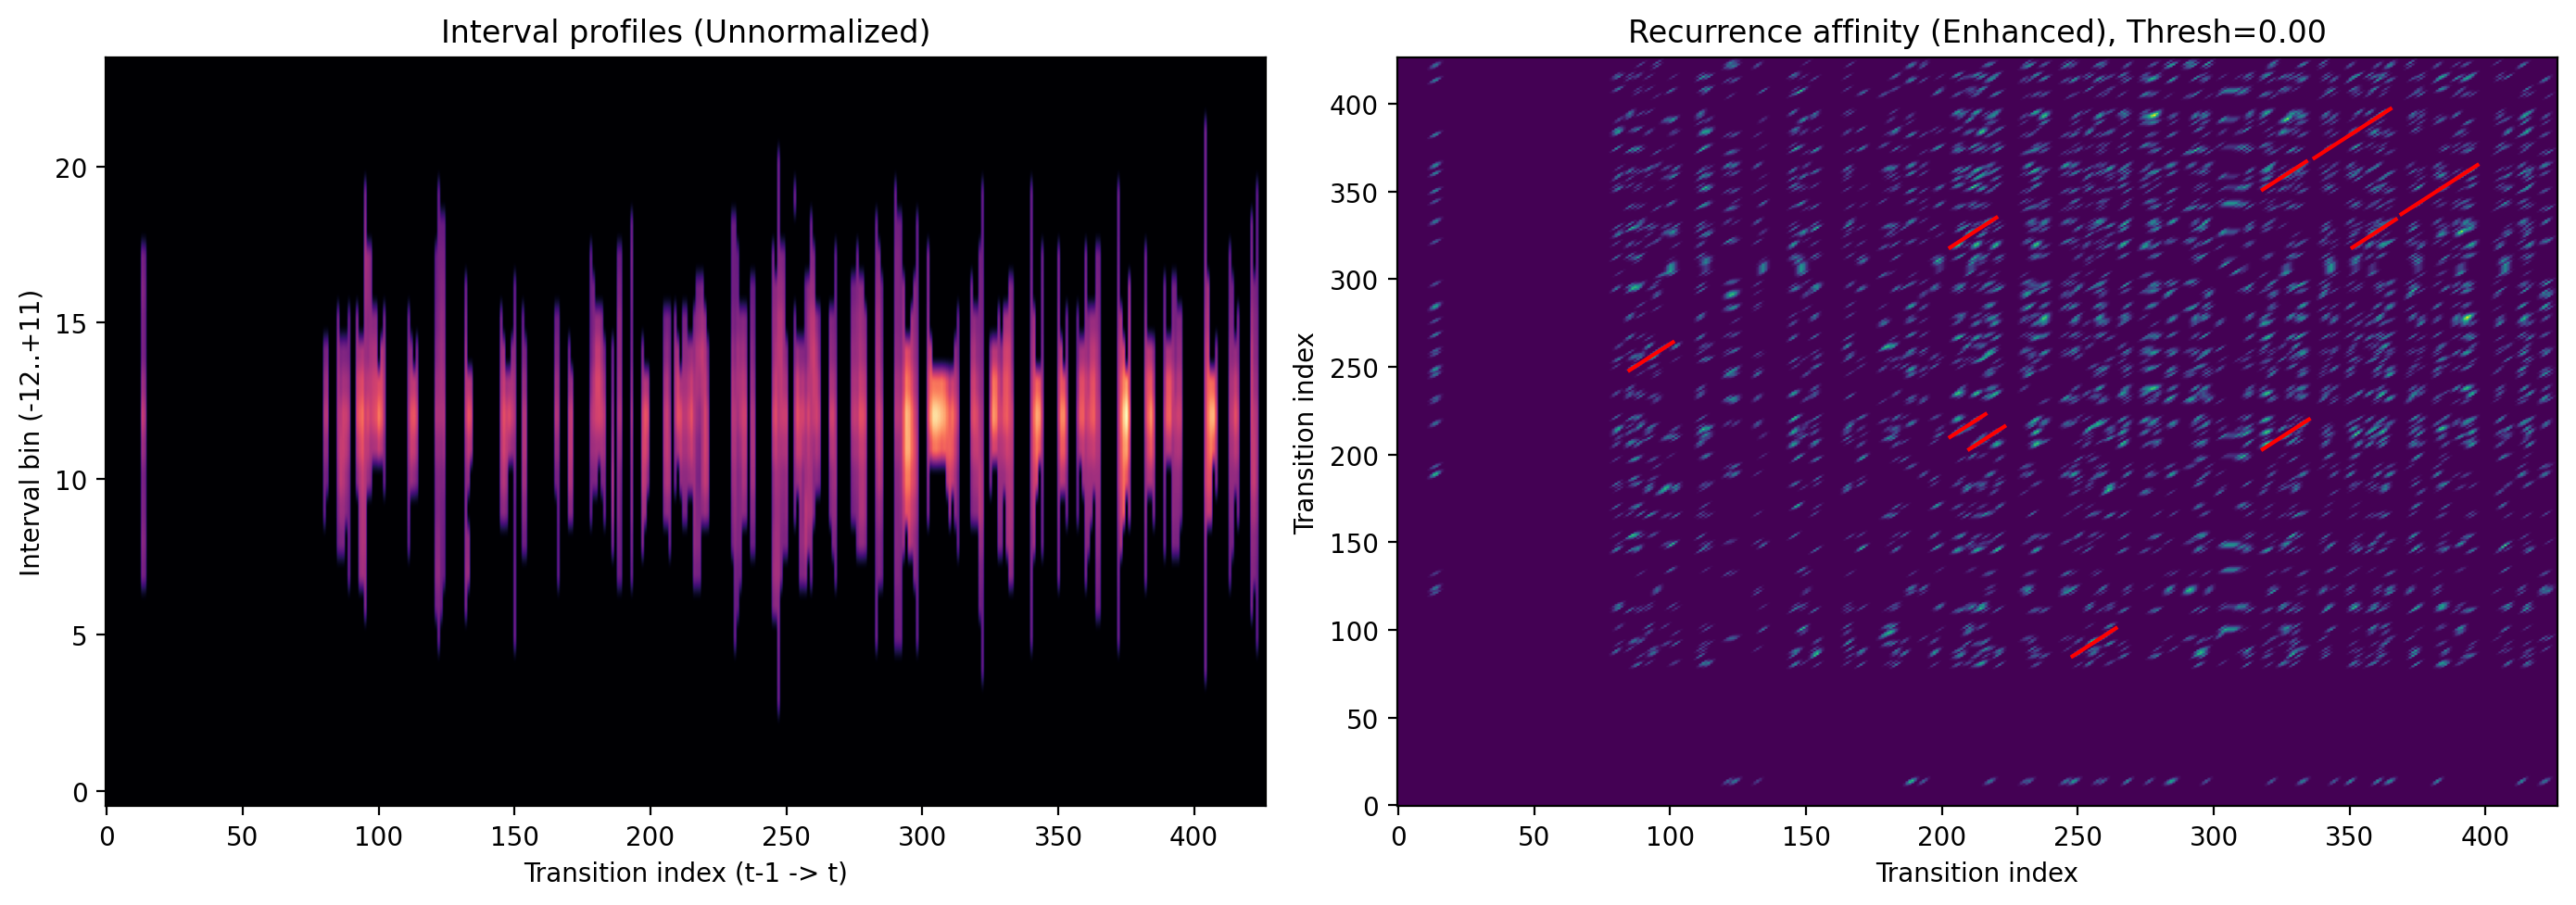

In [141]:
# --- モチーフ抽出: 音程差24ビン（休符なし・音域制限あり） ---
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d, uniform_filter1d, median_filter, gaussian_filter1d
import scipy.ndimage

# 設定
INTERVAL_BINS = 24               # 固定
INTERVAL_MIN = -12              # 24ビン: -12..+11
INTERVAL_MAX = 11
REC_WIDTH = 4                   # 近傍自己一致の除外幅
REC_MIN_LEN = 3                 # Motis length threshold
REC_Q = 0.60              # Top 50%

if INTERVAL_MAX - INTERVAL_MIN + 1 != INTERVAL_BINS:
    raise ValueError("INTERVAL_BINS must match INTERVAL_MIN..INTERVAL_MAX range")

# 1) 入力: biased_notes_prob を歌唱音域内に制限
pitch_lo = LOWEST_PITCH
pitch_hi = HIGHEST_PITCH
if not (0 <= pitch_lo <= pitch_hi < biased_notes_prob.shape[1]):
    raise ValueError("LOWEST_PITCH/HIGHEST_PITCH out of range for biased_notes_prob")

# 歌唱音域内の確率分布を抽出
notes_in_range = np.array(biased_notes_prob[:, pitch_lo:pitch_hi + 1], dtype=np.float64, copy=True)
notes_in_range[notes_in_range < 0] = 0.0

T, P = notes_in_range.shape
if T < 2:
    raise ValueError("Need at least 2 grids to compute interval transitions")

# 2) 各遷移 t-1 -> t で、音程差24ビンの確率分布を集計
interval_profiles = np.zeros((T - 1, INTERVAL_BINS), dtype=np.float64)
q_idx = np.arange(P, dtype=np.int32)  # 音高のインデックス配列

for t in range(1, T):
    prev_prob = notes_in_range[t - 1]
    curr_prob = notes_in_range[t]
    # 正規化していないため、確信度が低い区間では pair_prob も小さくなる
    pair_prob = np.outer(prev_prob, curr_prob)

    profile_t = interval_profiles[t - 1]
    for p in range(P):
        diff = q_idx - p
        valid = (diff >= INTERVAL_MIN) & (diff <= INTERVAL_MAX)
        if not np.any(valid):
            continue
        bin_idx = diff[valid] - INTERVAL_MIN
        np.add.at(profile_t, bin_idx, pair_prob[p, valid])

# 3) 平滑化
# 3-a) 局所平滑化（音程軸方向）
interval_profiles = gaussian_filter1d(interval_profiles, sigma=1.0, axis=1, mode="nearest")

# 3-b) 時間軸方向の平滑化
interval_profiles = uniform_filter1d(interval_profiles, size=3, axis=0, mode="nearest")

# 3-c) 【追加】ハード・スレッショルド (Noise Gating)
# 最大値に対する割合、または固定値で「紫色の霧」を消し飛ばします
# ここでは「各時刻の最大値の 40% 未満」をゴミとみなして0にします
peak_values = interval_profiles.max(axis=1, keepdims=True)
mask = interval_profiles < (peak_values * 0.8) 
interval_profiles[mask] = 0.0

# 3-d) コントラスト強調 (Power)
# 残った信号を際立たせる
interval_profiles = np.power(interval_profiles, 2)

# 各時刻のベクトルにおける「最大値」または「標準偏差」を計算
# ノイズ（平坦）なら標準偏差は低く、シグナル（鋭い）なら高くなります
peak_strength = interval_profiles.max(axis=1)
# あるいは std_dev = interval_profiles.std(axis=1)

# 全体の平均的な強さを基準にする
threshold_strength = np.mean(peak_values) * 0.8
# またはパーセンタイルで動的に決める
# threshold_strength = np.percentile(peak_strength, 40)

# 「ピークが低い（＝平坦でボヤけた）」フレームを特定
flat_noise_mask = peak_strength < threshold_strength

# 平坦なフレームを強制的にゼロベクトルにする
# これでコサイン類似度は 0.0 になり、マッチングしなくなる
interval_profiles[flat_noise_mask] = 0.0

# L2正規化 (前回と同じ)
norms = np.linalg.norm(interval_profiles, axis=1, keepdims=True)
norms[norms == 0] = 1.0 
interval_features = interval_profiles / norms

# 4) Recurrence Matrix
rec_input = interval_features.T  # shape: (features, time)
R = librosa.segment.recurrence_matrix(
    rec_input,
    k=None,
    width=REC_WIDTH,
    metric="cosine",
    mode="affinity",
    sym=True,
    sparse=False,
)

# --- 【強化】対角線強調 (Lag-Smoothing) ---
R_enhanced = librosa.segment.timelag_filter(gaussian_filter1d)(R, sigma=1.0, mode='mirror') # 
np.fill_diagonal(R_enhanced, 0.0)

# しきい値処理
valid_vals = R_enhanced[R_enhanced > 0]
print(f"R median: {np.median(valid_vals):.4f}, mean: {np.mean(valid_vals):.4f}, max: {R_enhanced.max():.4f}")
if valid_vals.size == 0:
    rec_threshold = 1.0
    print("Warning: No positive affinity pairs found in enhanced matrix.")
else:
    # 上位 Q%
    rec_threshold = np.percentile(valid_vals, (1.0 - REC_Q) * 100)

R_bin = (R_enhanced >= rec_threshold).astype(np.uint8)

def extract_diagonal_runs(R_aff, R_binary, min_len=8, min_offset=4):
    n = R_binary.shape[0]
    segments = []
    for offset in range(min_offset, n):
        diag_bin = np.diagonal(R_binary, offset=offset)
        if diag_bin.size < min_len:
            continue
        
        # ランレングス圧縮で高速化
        padded = np.concatenate(([0], diag_bin, [0]))
        diffs = np.diff(padded)
        starts = np.where(diffs == 1)[0]
        ends = np.where(diffs == -1)[0]
        
        for start, end in zip(starts, ends):
            length = end - start
            if length >= min_len:
                a0 = start
                b0 = start + offset
                diag_aff = np.diagonal(R_aff, offset=offset)
                score = float(np.mean(diag_aff[start:end]))
                segments.append({
                    "start_a": int(a0),
                    "start_b": int(b0),
                    "length": int(length),
                    "score": score,
                })
    
    segments.sort(key=lambda s: (s["score"] * s["length"], s["length"]), reverse=True)
    return segments

def overlap_1d(a0, a1, b0, b1):
    return not (a1 <= b0 or b1 <= a0)

def select_non_overlapping(segments, top_k=20):
    selected = []
    for seg in segments:
        a0, a1 = seg["start_a"], seg["start_a"] + seg["length"]
        b0, b1 = seg["start_b"], seg["start_b"] + seg["length"]
        ok = True
        for kept in selected:
            ka0, ka1 = kept["start_a"], kept["start_a"] + kept["length"]
            kb0, kb1 = kept["start_b"], kept["start_b"] + kept["length"]
            if overlap_1d(a0, a1, ka0, ka1) and overlap_1d(b0, b1, kb0, kb1):
                ok = False
                break
        if ok:
            selected.append(seg)
        if len(selected) >= top_k:
            break
    return selected

motif_candidates_all = extract_diagonal_runs(
    R_aff=R_enhanced,
    R_binary=R_bin,
    min_len=REC_MIN_LEN,
    min_offset=REC_WIDTH,
)
motif_segments = select_non_overlapping(motif_candidates_all, top_k=5)

# 後段で使うために保持
motif_interval_profiles = interval_profiles
motif_recurrence_affinity = R_enhanced
motif_recurrence_binary = R_bin

print(f"notes_in_range shape: {notes_in_range.shape}  (pitch bins: {pitch_lo}..{pitch_hi})")
print(f"interval_profiles shape: {interval_profiles.shape}  (24 bins, temporally smoothed)")
print(f"Recurrence stats: max={R_enhanced.max():.4f}, threshold={rec_threshold:.4f} (Top {REC_Q*100}%)")
print(f"motif candidates: all={len(motif_candidates_all)}, selected={len(motif_segments)}")

# グリッド→秒の変換テーブルを事前計算
# grid_frames_np はフレームインデックスを格納しているので librosa で秒に変換
grid_times_sec = librosa.frames_to_time(grid_frames_np, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

for idx, seg in enumerate(motif_segments, start=1):
    # interval_profiles[i] は grid i→i+1 の遷移
    # モチーフは grid start_a ~ start_a+length の区間に対応
    a0 = seg['start_a']
    aL = min(seg['start_a'] + seg['length'], len(grid_times_sec) - 1)
    b0 = seg['start_b']
    bL = min(seg['start_b'] + seg['length'], len(grid_times_sec) - 1)
    print(
        f"[{idx:02d}] A:{a0}-{a0 + seg['length'] - 1} "
        f"({grid_times_sec[a0]:.1f}s-{grid_times_sec[aL]:.1f}s) "
        f"B:{b0}-{b0 + seg['length'] - 1} "
        f"({grid_times_sec[b0]:.1f}s-{grid_times_sec[bL]:.1f}s) "
        f"len={seg['length']} ({grid_times_sec[aL] - grid_times_sec[a0]:.1f}s) "
        f"score={seg['score']:.4f}"
    )

# 5) 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(interval_profiles.T, aspect="auto", origin="lower", cmap="magma")
axes[0].set_title("Interval profiles (Unnormalized)")
axes[0].set_xlabel("Transition index (t-1 -> t)")
axes[0].set_ylabel("Interval bin (-12..+11)")

axes[1].imshow(R_enhanced, aspect="auto", origin="lower", cmap="viridis")
axes[1].set_title(f"Recurrence affinity (Enhanced), Thresh={rec_threshold:.2f}")
axes[1].set_xlabel("Transition index")
axes[1].set_ylabel("Transition index")

for seg in motif_segments[:10]:
    a0 = seg["start_a"]
    b0 = seg["start_b"]
    L = seg["length"]
    axes[1].plot([b0, b0 + L - 1], [a0, a0 + L - 1], color="red", linewidth=1.5)
    axes[1].plot([a0, a0 + L - 1], [b0, b0 + L - 1], color="red", linewidth=1.5)

plt.tight_layout()
plt.show()

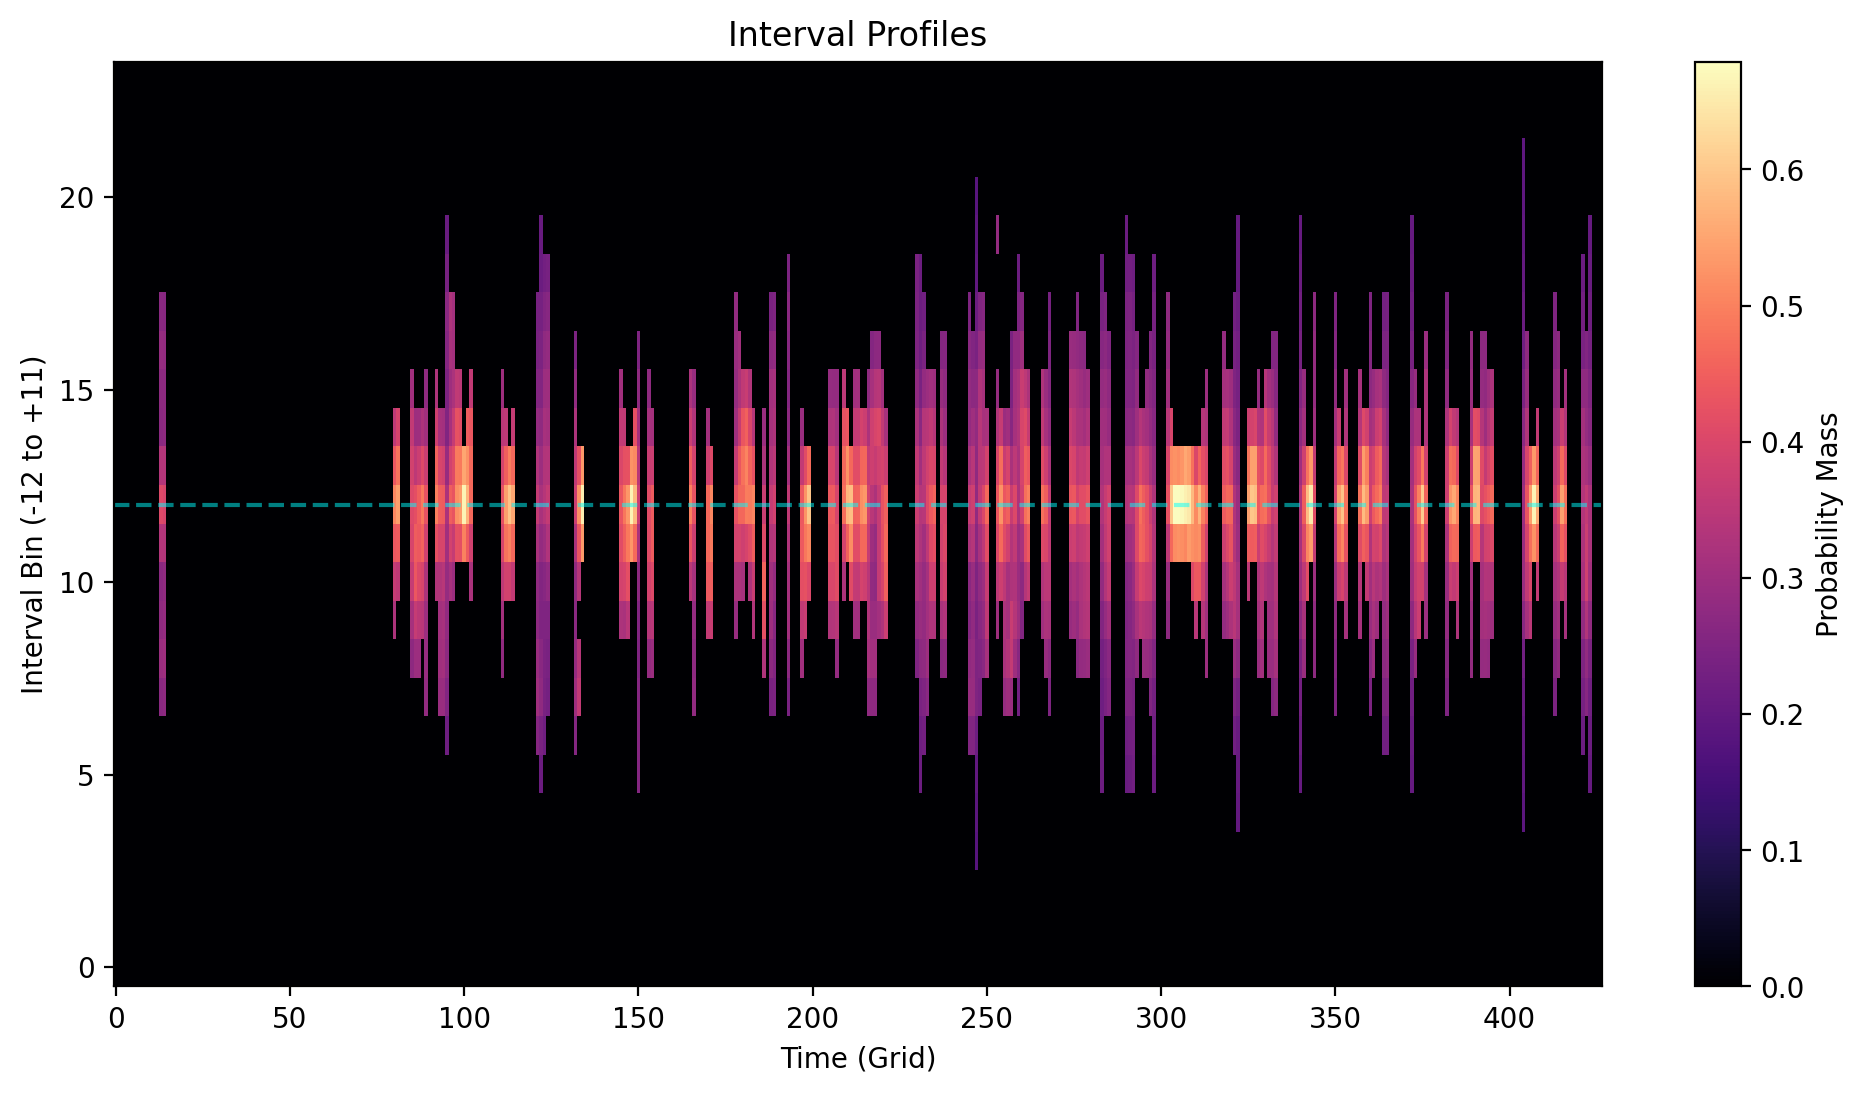

In [121]:
# --- デバッグ用可視化 ---
plt.figure(figsize=(12, 6))

# 0成分除去後のプロファイルを表示
debug_profiles = interval_features.copy()
# 視認性を上げるために対数表示などを検討しても良いが、まずは生で
plt.imshow(debug_profiles.T, aspect='auto', origin='lower', interpolation='nearest', cmap='magma')

plt.title("Interval Profiles")
plt.xlabel("Time (Grid)")
plt.ylabel("Interval Bin (-12 to +11)")
plt.colorbar(label="Probability Mass")

# 中心ビン（0半音）に線を引く
plt.axhline(y=-INTERVAL_MIN, color='cyan', linestyle='--', alpha=0.5)

plt.show()

In [83]:
print(f"R max: {R.max():.4f}, mean: {R.mean():.4f}")
print(f"upper_pos stats: size={upper_pos.size}")
if upper_pos.size > 0:
    print(f"  min={upper_pos.min():.4f}, max={upper_pos.max():.4f}, mean={upper_pos.mean():.4f}")
    print(f"  20%ile (REC_Q={REC_Q}): {np.quantile(upper_pos, REC_Q):.4f}")
    print(f"  80%ile: {np.quantile(upper_pos, 0.80):.4f}")

print(f"rec_threshold used: {rec_threshold:.4f}")
print(f"R_bin count (ones): {R_bin.sum()} / {R_bin.size} ({100*R_bin.sum()/R_bin.size:.2f}%)")

# Check diagonal lengths manually for a few offsets
diag_lens = []
for offset in range(REC_WIDTH, R_bin.shape[0]):
    d = np.diagonal(R_bin, offset=offset)
    if d.size == 0: continue
    # simple run length encoding
    runs = np.diff(np.concatenate(([0], d, [0])))
    starts = np.where(runs == 1)[0]
    ends = np.where(runs == -1)[0]
    lengths = ends - starts
    if len(lengths) > 0:
        diag_lens.extend(lengths)

if diag_lens:
    diag_lens = np.array(diag_lens)
    print(f"\nDiagonal run lengths (offset >= {REC_WIDTH}):")
    print(f"  count: {len(diag_lens)}")
    print(f"  min: {diag_lens.min()}")
    print(f"  max: {diag_lens.max()}")
    print(f"  mean: {diag_lens.mean():.2f}")
    print(f"  median: {np.median(diag_lens):.2f}")
    print(f"  >= {REC_MIN_LEN}: {np.sum(diag_lens >= REC_MIN_LEN)}")
else:
    print("\nNo diagonal runs starting with 1 found.")

R max: 1.0000, mean: 0.0272
upper_pos stats: size=4298
  min=0.0006, max=0.9997, mean=0.6394
  20%ile (REC_Q=0.9): 0.9937
  80%ile: 0.9833
rec_threshold used: 0.5267
R_bin count (ones): 1214 / 182329 (0.67%)

Diagonal run lengths (offset >= 4):
  count: 133
  min: 1
  max: 15
  mean: 4.41
  median: 4.00
  >= 5: 58


In [56]:
interval_profiles[200]

array([0.28734842, 0.01437706, 0.01660245, 0.01526244, 0.01649374,
       0.01828894, 0.01506151, 0.01888671, 0.01625594, 0.01837025,
       0.01782803, 0.01827652, 0.02660449, 0.01719252, 0.01917115,
       0.01717766, 0.01735398, 0.01887874, 0.01497488, 0.01825377,
       0.01532612, 0.01624113, 0.01546769, 0.33030586])

#### キーに基づくノート推定 Dynamic Programming

In [34]:
grid_notes_prob_np = assigned_pitch.copy()
# 人が歌える音域外の音を除去
grid_notes_prob_np[:, :LOWEST_PITCH] = -np.inf
grid_notes_prob_np[:, HIGHEST_PITCH + 1:] = -np.inf
# 無音の確率を追加
temperature = 0.8
rest_prob = np.expand_dims(np.ones(grid_notes_prob_np.shape[0]) - grid_notes_prob_np.max(axis=1), axis=1)
grid_notes_prob_np = np.concatenate([grid_notes_prob_np, rest_prob], axis=1)
grid_notes_prob_np = np.exp(grid_notes_prob_np / temperature) / np.sum(np.exp(grid_notes_prob_np / temperature), axis=1, keepdims=True)
print(f"grid_notes_prob_np shape: {grid_notes_prob_np.shape}")

grid_notes_prob_np shape: (428, 89)


In [44]:
n_grids, n_note_states = grid_notes_prob_np.shape  # n_note_states = 88 + 1 (Rest)
n_pitches = n_note_states - 1
REST_STATE = n_pitches

# key_sequence の長さを n_grids に合わせる
if len(key_sequence) < n_grids:
    print(f"Warning: key_sequence ({len(key_sequence)}) < n_grids ({n_grids}). Padding.")
    key_sequence_padded = np.pad(key_sequence, (0, n_grids - len(key_sequence)), mode='edge')
elif len(key_sequence) > n_grids:
    key_sequence_padded = key_sequence[:n_grids]
else:
    key_sequence_padded = key_sequence

# 許可音域マスク（LOWEST_PITCH〜HIGHEST_PITCHのみ遷移可）
allowed_pitch_mask = np.zeros(n_pitches, dtype=bool)
allowed_pitch_mask[LOWEST_PITCH:HIGHEST_PITCH + 1] = True

# 動的遷移パラメータ
PITCH_STAY_PROB = 0.05
PITCH_TO_REST_PROB = 0.20
REST_STAY_PROB = 0.05
JUMP_SIGMA = 6.0
KEY_IN_WEIGHT = 1.0
KEY_OUT_WEIGHT = 0.2


def get_key_scale_mask_for_pitches(key_idx, n_pitches=88, midi_offset=21):
    """
    key_idx(0-11 Major, 12-23 Minor)に対し、各ピッチがスケール内かのboolマスクを返す。
    Returns:
        (n_pitches,) のbool配列 
    """
    root = key_idx % 12
    is_minor = key_idx >= 12

    if is_minor:
        intervals = {0, 2, 3, 5, 7, 8, 10}
    else:
        intervals = {0, 2, 4, 5, 7, 9, 11}

    mask = np.zeros(n_pitches, dtype=bool)
    for i in range(n_pitches):
        pitch_class = (i + midi_offset) % 12
        rel = (pitch_class - root + 12) % 12
        mask[i] = rel in intervals
    return mask


def build_dynamic_transition(key_idx):
    """
    調性依存の遷移行列 A_t を構築。
    - 音域外への遷移は確率0 (ハード制約)
    - 近傍遷移を優先しつつ、キー外音は減衰
    """
    A = np.zeros((n_note_states, n_note_states), dtype=np.float64)

    in_scale_mask = get_key_scale_mask_for_pitches(key_idx, n_pitches, MIDI_OFFSET)
    in_scale_allowed = in_scale_mask & allowed_pitch_mask

    # Rest -> ...
    A[REST_STATE, REST_STATE] = REST_STAY_PROB
    # 休符状態から許可音域への遷移確率は均等配分
    if np.any(allowed_pitch_mask):
        w = np.where(in_scale_allowed, KEY_IN_WEIGHT, KEY_OUT_WEIGHT).astype(np.float64)
        w[~allowed_pitch_mask] = 0.0
        sw = w.sum()
        if sw > 0:
            A[REST_STATE, :n_pitches] = (1.0 - REST_STAY_PROB) * (w / sw)

    # Pitch -> ...
    for i in range(n_pitches):
        # 許可音域がない場合は休符へ遷移
        if not allowed_pitch_mask[i]:
            A[i, REST_STATE] = 1.0
            continue

        A[i, i] = PITCH_STAY_PROB
        A[i, REST_STATE] = PITCH_TO_REST_PROB

        remaining = 1.0 - PITCH_STAY_PROB - PITCH_TO_REST_PROB
        if remaining <= 0:
            continue

        w = np.zeros(n_pitches, dtype=np.float64)
        for j in range(n_pitches):
            # 許可音域外への遷移は0
            if i == j or (not allowed_pitch_mask[j]):
                continue
            # 跳躍に関する制約
            dist = abs(i - j)
            jump_w = np.exp(-0.5 * (dist / JUMP_SIGMA) ** 2)
            # スケール内制約
            key_w = KEY_IN_WEIGHT if in_scale_mask[j] else KEY_OUT_WEIGHT
            w[j] = jump_w * key_w

        sw = w.sum()
        # 同一音・休符以外への遷移確率を分配
        if sw > 0:
            A[i, :n_pitches] += remaining * (w / sw)

    # 音域外への遷移を明示的に0
    A[:, :LOWEST_PITCH] = 0.0
    A[:, HIGHEST_PITCH + 1:n_pitches] = 0.0

    # 行正規化（ゼロ除算回避）
    row_sum = A.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    A /= row_sum

    return A


def safe_log_prob(x, eps=1e-12):
    """確率配列をlog確率へ変換。0は -inf として扱う。"""
    y = np.full_like(x, -np.inf, dtype=np.float64)
    pos = x > 0
    y[pos] = np.log(np.maximum(x[pos], eps))
    return y


def viterbi_dynamic(grid_prob, key_seq):
    """
    grid_prob: (T, N) 各時刻の観測確率
    key_seq:   (T,)   各時刻のキーインデックス
    returns: best_path (T,)
    """
    T, N = grid_prob.shape

    # Emission log-prob
    emission = np.array(grid_prob, dtype=np.float64, copy=True)

    # ハード制約: 音域外ピッチの観測確率は0
    emission[:, :LOWEST_PITCH] = 0.0
    emission[:, HIGHEST_PITCH + 1:n_pitches] = 0.0

    # 行ごと正規化（念のため）
    row_sum = emission.sum(axis=1, keepdims=True)
    row_sum[row_sum == 0] = 1.0
    emission /= row_sum

    log_emission = safe_log_prob(emission)

    # 初期確率
    p_init = np.zeros(N, dtype=np.float64)
    n_allowed = allowed_pitch_mask.sum()
    if n_allowed > 0:
        p_init[:n_pitches][allowed_pitch_mask] = 0.9 / n_allowed
    p_init[REST_STATE] = 0.1
    p_init = p_init / p_init.sum()
    log_init = safe_log_prob(p_init)

    dp = np.full((T, N), -np.inf, dtype=np.float64)
    backptr = np.zeros((T, N), dtype=np.int32)

    dp[0] = log_init + log_emission[0]

    for t in range(1, T):
        A_t = build_dynamic_transition(int(key_seq[t]))
        log_A_t = safe_log_prob(A_t)

        # scores[i, j] = dp[t-1, i] + log_A_t[i, j]
        scores = dp[t - 1][:, None] + log_A_t
        backptr[t] = np.argmax(scores, axis=0)
        dp[t] = scores[backptr[t], np.arange(N)] + log_emission[t]

    best_path = np.zeros(T, dtype=np.int32)
    best_path[-1] = int(np.argmax(dp[-1]))
    for t in range(T - 2, -1, -1):
        best_path[t] = backptr[t + 1, best_path[t + 1]]

    return best_path


# ====================================================================
# 2. 動的Viterbi実行
# ====================================================================
note_sequence_indices = viterbi_dynamic(grid_notes_prob_np, key_sequence_padded)
print(f"[2/3] Dynamic Viterbi done. T={len(note_sequence_indices)}, N={n_note_states}")

# 結果を元のフォーマットに変換 (MIDI保存用)
# 出力は状態インデックスなので、One-hotに変換 (Rest列なし)
grid_notes_hmm = np.zeros_like(grid_notes_np)  # (n_grids, 88)

n_rest = 0
n_note = 0
for t, state_idx in enumerate(note_sequence_indices):
    if state_idx < n_pitches:
        grid_notes_hmm[t, state_idx] = 1.0
        n_note += 1
    else:
        n_rest += 1

print(f"[3/3] Decoded. Notes: {n_note} grids, Rest: {n_rest} grids")
print(f"  grid_notes_hmm shape: {grid_notes_hmm.shape}")

output_hmm_midi = os.path.join(transcription_path, 'vocals_hmm.mid')
_ = save_grid_to_midi(
    grid_onsets_np,
    grid_notes_hmm,
    grid_frames_np,
    SPF,
    pitch_threshold=0.33,
    output_filename=output_hmm_midi,
)

[2/3] Dynamic Viterbi done. T=428, N=89
[3/3] Decoded. Notes: 275 grids, Rest: 153 grids
  grid_notes_hmm shape: (428, 88)
grid_onsets_np shape: (428, 88), grid_notes_np shape: (428, 88)
Saved MIDI to /Users/kpome/github/solfege-gen/data/processed/transcribed/sample_kaze/vocals_hmm.mid (252 notes)


In [37]:
import music21
# 楽譜として表示する (music21ライブラリを使用)
# 注意: きれいな楽譜を表示するには、OSに MuseScore などの楽譜ソフトがインストールされている必要があります。

score = music21.converter.parse(output_midi_path)

In [28]:
print(type(score))
score.show('midi')  # 'musicxml.png' を使用してPNG画像として表示

<class 'music21.stream.base.Score'>


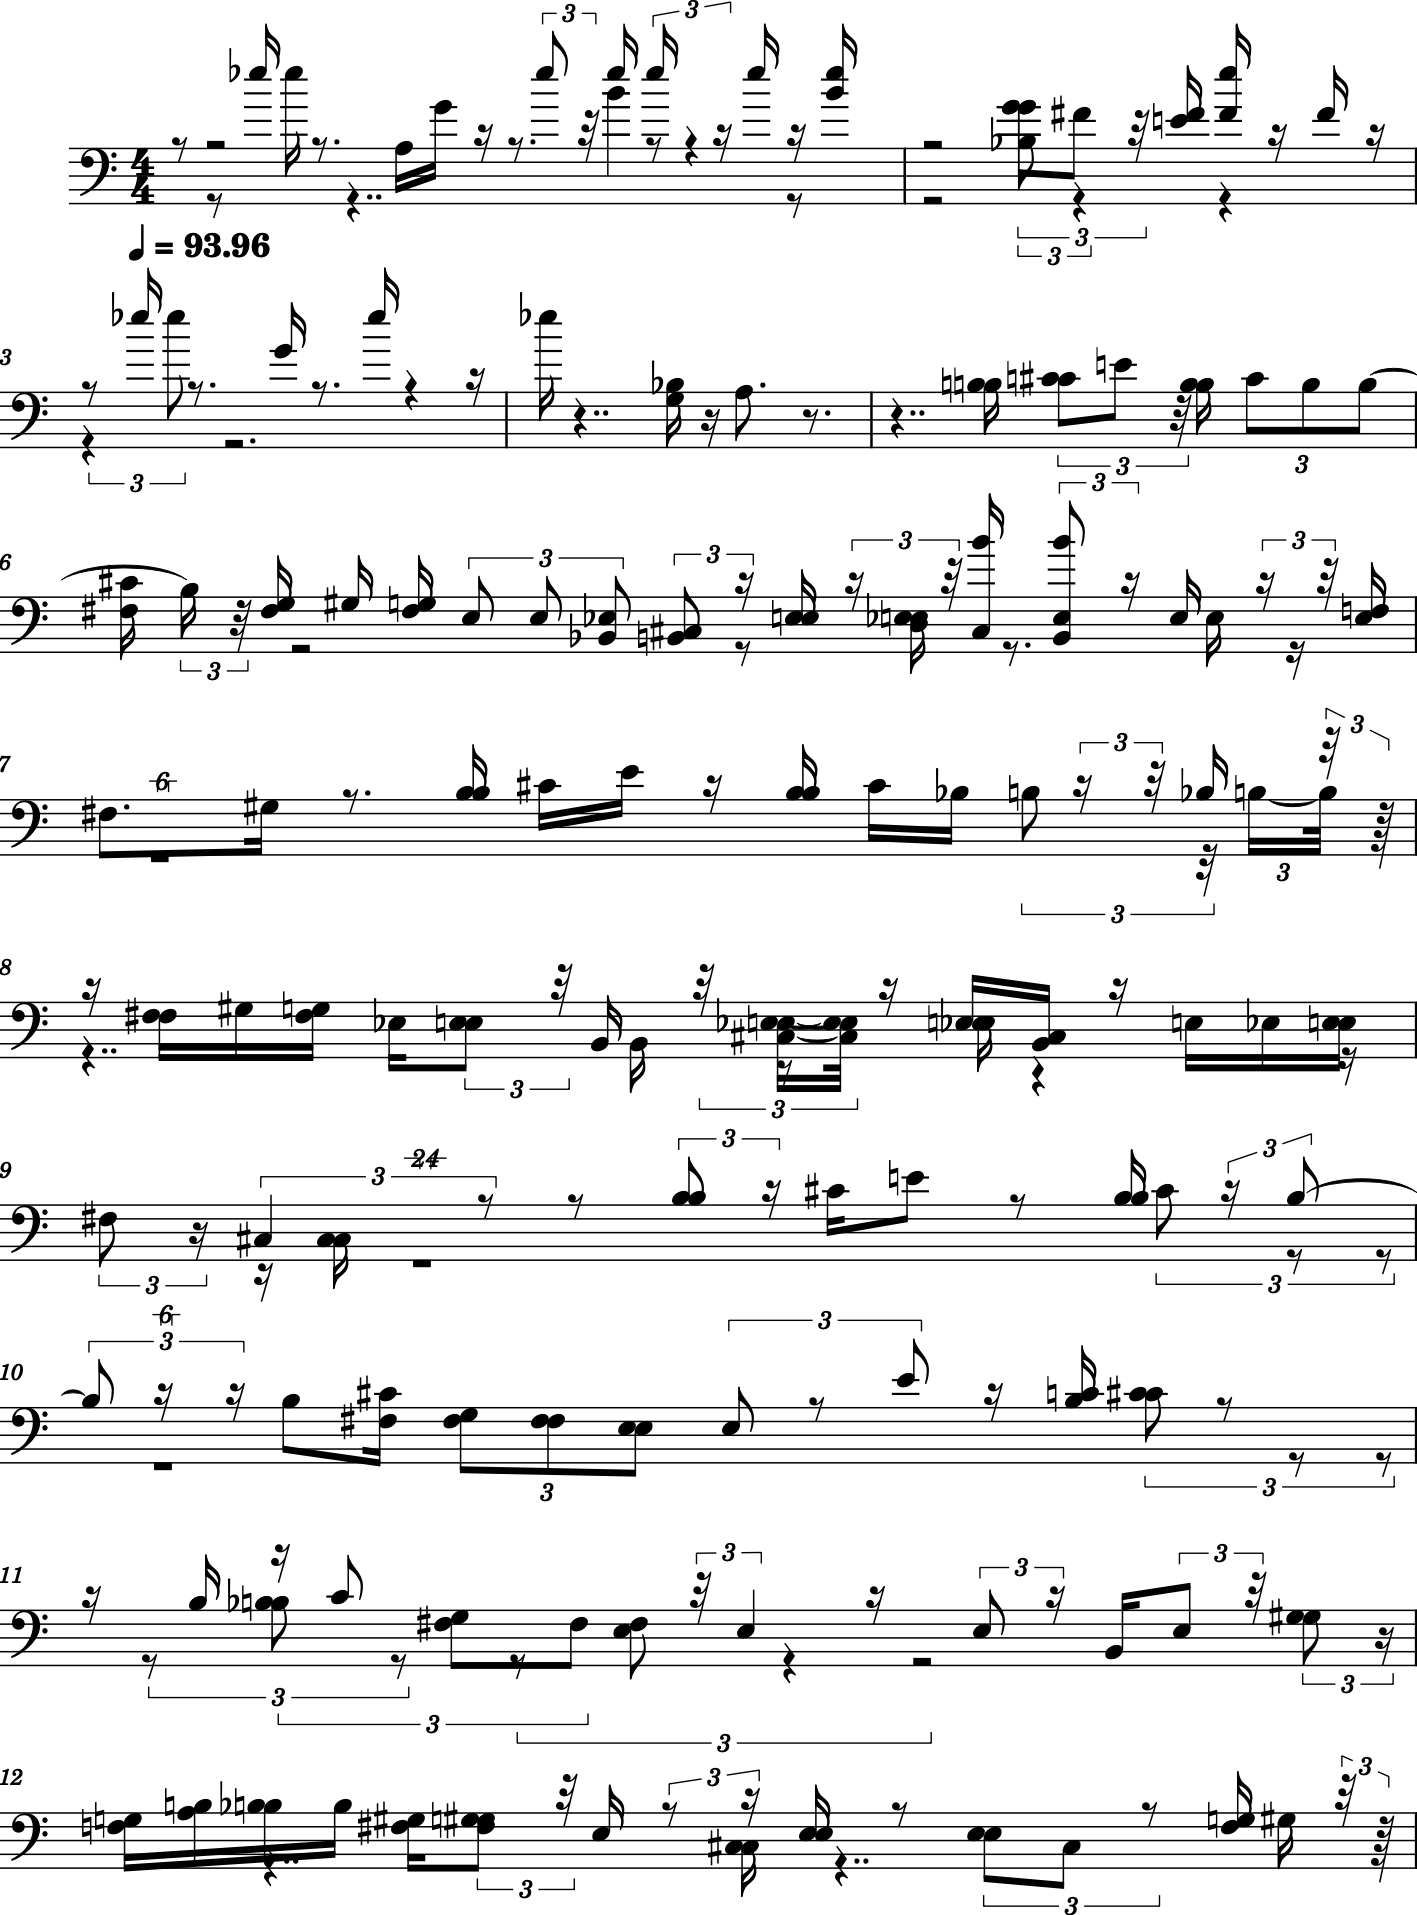

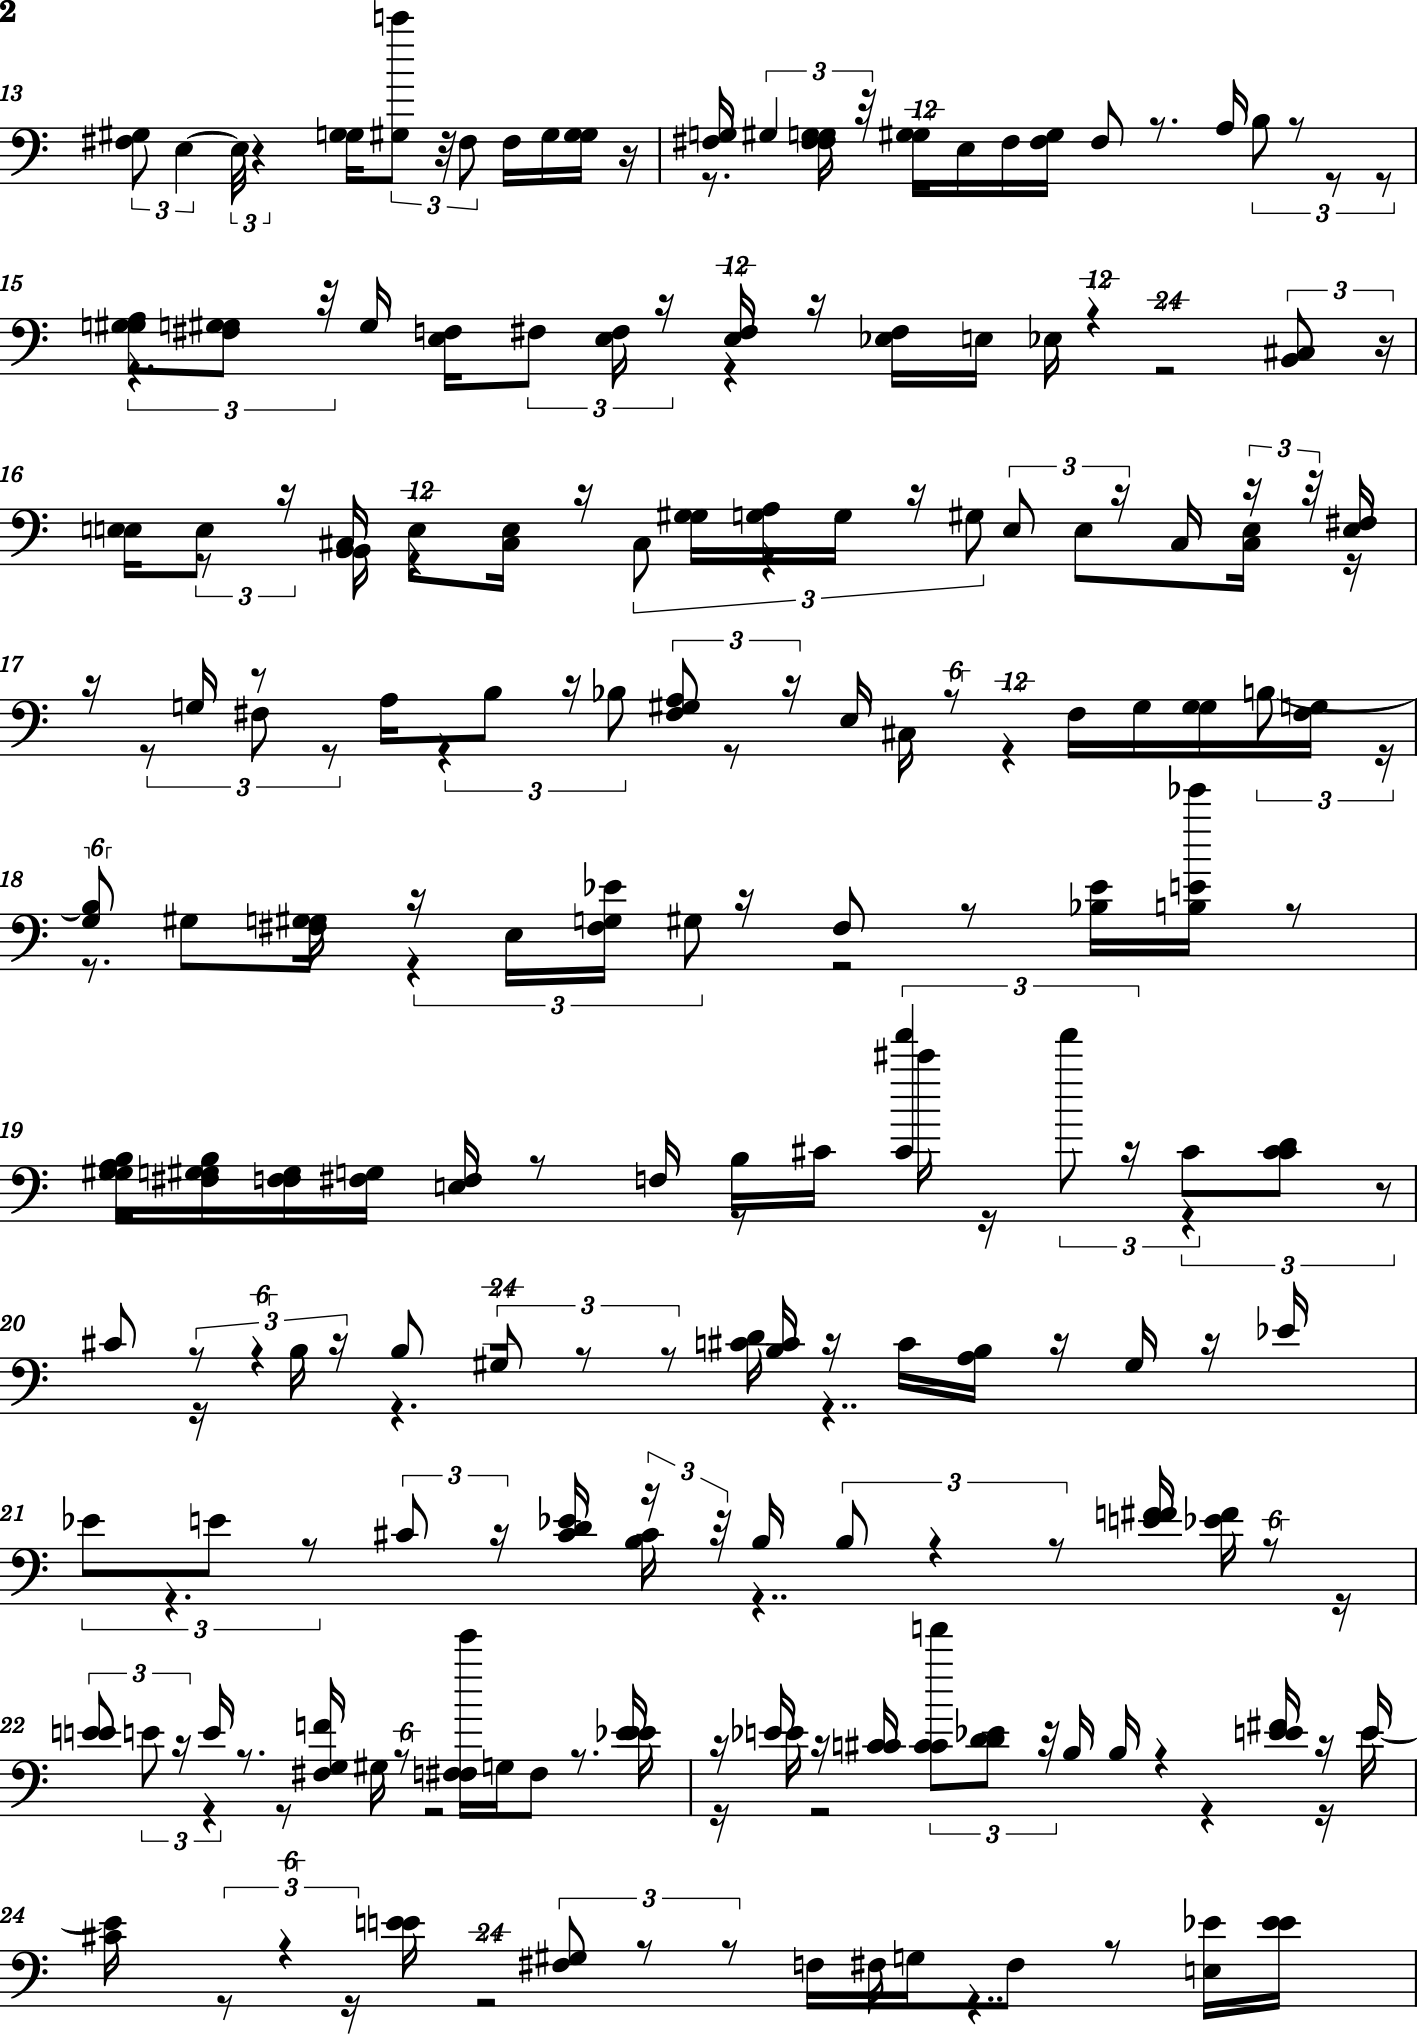

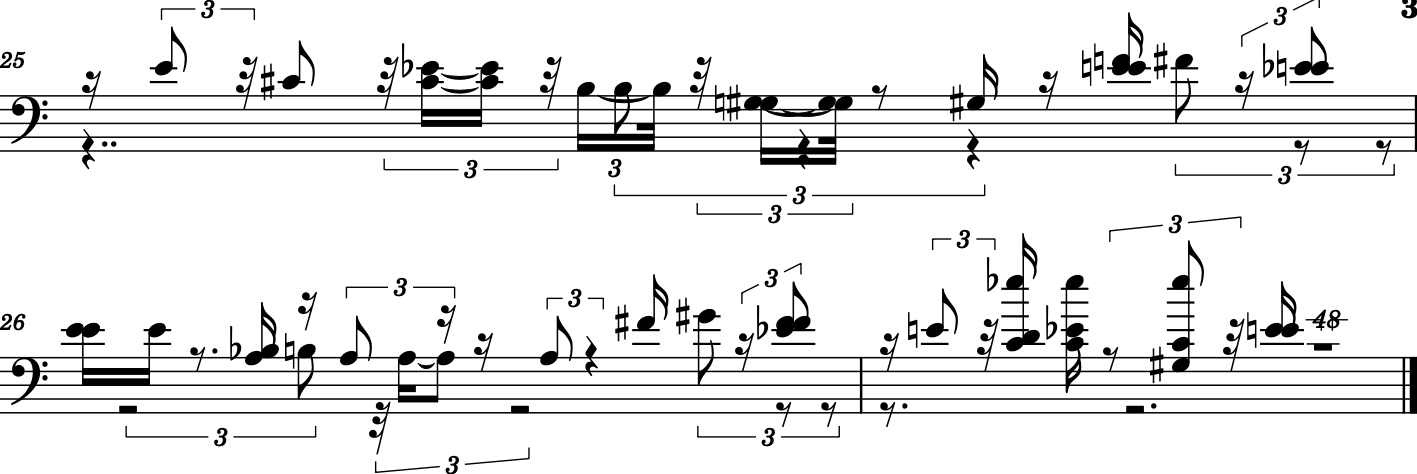

In [29]:

try:
    # 保存したMIDIファイルを読み込む

    
    # 楽譜を外部ビューアで表示

    # MuseScoreなどがインストールされていれば起動します
    score.show()
    
    # ノートブック上で簡易的に確認したい場合はテキスト形式で表示できます
    # score.show('text')
    
except Exception as e:
    print(f"楽譜の表示に失敗しました: {e}")
    print("MuseScoreなどがインストールされていない場合は、'music21' の設定が必要な場合があります。")